In [1]:
import numpy as np 
import pandas as pd
import random as rm
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Simulations of particle trajectories

In [2]:
def normal_diff(delta_time, diffusion_coefficient, min_tlength, max_tlength, sigma, num_traces):
    traces = []
    track_length = np.random.randint(min_tlength,max_tlength,size=num_traces)
    
    for n in range(num_traces-1):
        two_D_t = 2*diffusion_coefficient[n]*delta_time
        trace_n = np.zeros(shape = (1,2))
        
        for step in range(track_length[n]-1):
            step_x = np.random.normal(loc=0.0, scale=np.sqrt(two_D_t), size=1)
            step_y = np.random.normal(loc=0.0, scale=np.sqrt(two_D_t), size=1)
            
            xy = np.hstack((step_x,step_y))
            trace_step = trace_n[step] + xy
            
            trace_n = np.vstack((trace_n,trace_step))
            
        traces.append((trace_n))
    
    matrix_x, matrix_y = np.empty(shape=(1, max_tlength)), np.empty(shape=(1, max_tlength))
    
    for trace_m in traces:
        trace_m_x, trace_m_y = trace_m[:,0], trace_m[:,1]

        delta_length = max_tlength-len(trace_m_x)
        zero = np.zeros(shape = (delta_length))
        
        trace_x_ex = np.hstack((zero, trace_m_x))
        trace_y_ex = np.hstack((zero, trace_m_y))
        
        matrix_x = np.vstack((matrix_x, trace_x_ex))
        matrix_y = np.vstack((matrix_y, trace_y_ex))
        
    
    return traces, matrix_x, matrix_y

In [4]:
dt = 1/30
num_traces = 800 #increase
dim = 2
D_track = np.full((800,),0.5)
# D_track = np.random.uniform(low = 10**-3, high = 1, size=(num_traces))
min_tlength = 50
max_tlength = 100
q = np.random.uniform(1,9, size=num_traces)
sigmaND = np.sqrt(D_track*dt)/q

traces_test, matrix_x_test, matrix_y_test = normal_diff(dt,D_track,min_tlength,max_tlength,sigmaND,num_traces)

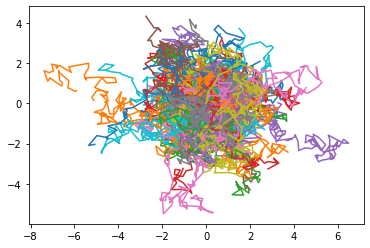

In [18]:
for i in range(len(traces_test)):
    plt.plot(traces_test[i][:,0],traces_test[i][:,1])

In [6]:
# plt.hist(D_track,bins=10000)
# plt.xlabel('Diffusion coefficients')
# plt.ylabel('Occurence')

In [23]:
# plt.hist(track_length_test,bins=int(np.sqrt(num_traces)))
# plt.xlabel('Track lengths')
# plt.ylabel('Occurence')

# Machine learning with GPR

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [8]:
np.where(np.isnan(matrix_y_test))
# np.isnan(matrix_x_test).any

(array([0], dtype=int64), array([96], dtype=int64))

In [11]:
matrix_x_test[0,96]

1.8383887402430983

In [12]:
# matrix_x_test[0, :]

In [14]:
# matrix_y_test[0, :]

In [10]:
# kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e20))
# gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)

# gaussian_process.fit(matrix_x_test[:80],D_track[:80])
# gx = gaussian_process.predict(matrix_x_test[80:])

# gaussian_process.fit(matrix_y_test[:80],D_track[:80])
# gy = gaussian_process.predict(matrix_y_test[80:])

In [108]:
matrix_x_test[:80].shape

(10, 100)

In [50]:
result = np.add(gx,gy)/2

from sklearn.metrics import mean_squared_error
mean_squared_error(D_track[80:],result)

1.5603776810030508e-24

Text(0, 0.5, 'Occurence')

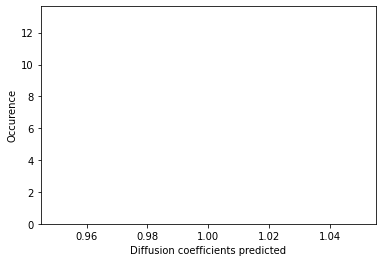

In [35]:
plt.hist(result)
plt.xlabel('Diffusion coefficients predicted')
plt.ylabel('Occurence')

# Fit for mean squared displacement (MSD)

In [5]:
def SquareDist(x0, x1, y0, y1):
    return (x1 - x0) ** 2 + (y1 - y0) ** 2

In [6]:
def linear(a,b,x):
    y = a*x+b
    return y

In [7]:
def msd(t, frac):
    if t.shape[1]==2:
        x = t[:,0]
        y = t[:,1]
    elif t.shape[1]==3:
        x = t[:,0]
        y = t[:,1]

    N = int(len(x) * frac) if len(x)>10 else len(x)
    msd = []
    for lag in range(1, N):
        msd.append(np.mean([SquareDist(x[j], x[j + lag], y[j], y[j + lag])
        for j in range(len(x) - lag)]))
    return np.array(msd)

In [8]:
MSDs = []

for t in traces_test:
    MSDs.append(msd(t, 1))
MSDs = np.array(MSDs, dtype=object)
MSDs.shape
# print(len(MSDs[0]))

a_list = []
b_list = []
d_list = []
from sklearn import preprocessing

# # https://docs.mdanalysis.org/2.0.0/documentation_pages/analysis/msd.html - computation of MSDs is highly memory intensive
# # https://github.com/deepankarkotnala/Linear-Regression-Python/blob/master/README.md

In [9]:
import random

def random_color():
    rgbl=[round(random.uniform(0, 1),1),round(random.uniform(0, 1),1),round(random.uniform(0, 1),1)]
    return tuple(rgbl)

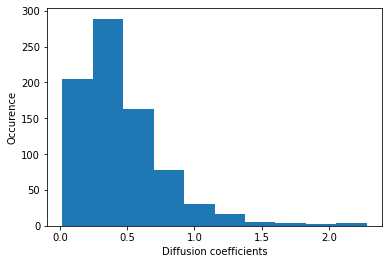

In [22]:
from scipy.stats import linregress
from matplotlib.pyplot import cm

def msd_func(x,D,alpha):
    return 2*dim*D*(x)**alpha

x_data_list = []
slope_list = []
error_list = []
diff_coeff_list = []  
color_list = []

for j in range(len(MSDs)):
    color_list.append(random_color())
    start_time = 0
    start_index = int(start_time/dt)
    end_time = len(MSDs[j])
    end_index = int(end_time/dt)
    x_data = [*range(0,len(MSDs[j]))]
    x_data_list.append(np.array(x_data))
    xx = x_data_list[j][:,np.newaxis]
    a,resid,_,_ = np.linalg.lstsq(xx, MSDs[j], rcond=None)
    # plt.plot(MSDs[j],color = color_list[j],label='MSD')
    # plt.plot(xx, a*xx, color = color_list[j], linestyle='dashed', label=r'$y=4*D*t$')
    # plt.xlabel(r'$\tau$')
    # plt.legend()
    # plt.figure()
    # r_squared = 1 - (resid / (MSDs[j].size * MSDs[j].var()))
    r_squared = 1 - resid / (sum((MSDs[j] - MSDs[j].mean())**2))
    error_list.append(r_squared)
    msds = MSDs[j]
    x = np.arange(1,len(msds) + 1)*dt
    popt,pcov = curve_fit(msd_func,x,msds)
    
    diff_coeff = popt[0]
    diff_coeff_list.append(diff_coeff)
    
# print(diff_coeff_list)
    
plt.hist(np.array(diff_coeff_list))
plt.xlabel('Diffusion coefficients')
plt.ylabel('Occurence')
plt.show()
# print(min(diff_coeff_list))

Text(0, 0.5, 'Occurence')

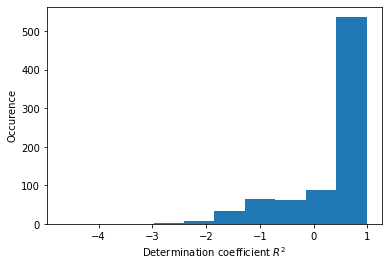

In [15]:
# print(np.array(error_list)
plt.hist(np.array(error_list))
plt.xlabel('Determination coefficient $R^2$')
plt.ylabel('Occurence')

Text(0, 0.5, 'Occurence')

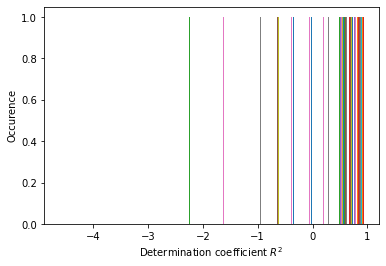

In [13]:
plt.hist(error_list)
plt.xlabel('Determination coefficient $R^2$')
plt.ylabel('Occurence')

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(D_track[:num_traces-1],diff_coeff_list)

0.10994895916105434